In [1]:
import os
import numpy as np
import tensorflow as tf
import json
from tensorflow.keras.models import model_from_json
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from tqdm.auto import tqdm
from utils import *
import cv2
import plotly.graph_objects as go
from scipy.signal import butter, sosfilt
from tensorflow.keras.losses import binary_focal_crossentropy

## Create Dataset

In [2]:
volume_size = 128
def butter_bandpass(seismic, lowcut, highcut):
    order = 4
    fs = 250
    sos = butter(order, [lowcut,highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, seismic)

def parse_folder_structure(base_path):
    sample_pairs = []
    for sample_id in os.listdir(base_path):
        sample_path = os.path.join(base_path, sample_id)
        if os.path.isdir(sample_path):
            seismic_file = None
            fault_file = None
            for file in os.listdir(sample_path):
                if file.startswith("seismicCubes_") and file.endswith(".npy"):
                    seismic_file = os.path.join(sample_path, file)
                elif file.startswith("fault_") and file.endswith(".npy"):
                    fault_file = os.path.join(sample_path, file)
            if seismic_file and fault_file:
                sample_pairs.append((seismic_file, fault_file))
    return sample_pairs

def data_generator(data_pairs, num_samples):
    faultless_ratios = [0,0.1,0.2,0.3]
    repeat_count = 0
    while True:
        if repeat_count < len(faultless_ratios):
            faultless_ratio = faultless_ratios[repeat_count]
        else:
            faultless_ratio = faultless_ratios[-1]

        for seismic_path, fault_path in data_pairs:
            fault = np.load(fault_path)
            seismic = np.load(seismic_path)
            # seismic = butter_bandpass(seismic,5,30)
            # seismic = rescale_volume(np.load(seismic_path),1,99)
            depth, height, width = fault.shape
            min_fault = 4096

            for i in range(num_samples):
                with_fault = np.random.rand() > faultless_ratio
                for j in range(16):
                    d_start = np.random.randint(0, depth - volume_size + 1)
                    h_start = np.random.randint(0, height - volume_size + 1)
                    w_start = np.random.randint(0, width - volume_size + 1) ####前處理重點
                    fault_volume = fault[d_start:d_start+volume_size, h_start:h_start+volume_size, w_start:w_start+volume_size]
                    num_fault = np.sum(fault_volume == 1)
                    
                    # Check the condition based on `with_fault`
                    if (num_fault >= min_fault) == with_fault:
                        seismic_volume = seismic[d_start:d_start+volume_size, h_start:h_start+volume_size, w_start:w_start+volume_size]
                        seismic_volume = np.expand_dims(seismic_volume, axis=-1)
                        fault_volume = np.expand_dims(fault_volume, axis=-1)
                        yield seismic_volume, fault_volume
                        break

        repeat_count += 1

def create_tf_dataset(data_pairs, num_samples, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data_pairs, num_samples),
        output_signature=(
            tf.TensorSpec(shape=(volume_size, volume_size, volume_size, 1), dtype=tf.float32),  # Seismic volume
            tf.TensorSpec(shape=(volume_size, volume_size, volume_size, 1), dtype=tf.uint8),    # Fault volume
        ),
    )
    dataset = dataset.shuffle(128).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

### Build Model

In [3]:
def unet(pretrained_weights = None,input_size = (None,None,None,1)):
    inputs = layers.Input(input_size)
    conv1 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2,2,2))(conv1)

    conv2 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2,2,2))(conv2)

    conv3 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling3D(pool_size=(2,2,2))(conv3)

    conv4 = layers.Conv3D(512, (3,3,3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(512, (3,3,3), activation='relu', padding='same')(conv4)

    up5 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv4), conv3])
    conv5 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(conv5)

    up6 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv5), conv2])
    conv6 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(conv6)

    up7 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv6), conv1])
    conv7 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(conv7)

    conv8 = layers.Conv3D(1, (1,1,1), activation='sigmoid')(conv7)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv8])
    return model

### Training

In [4]:
# save model and history on epoch end
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path
    def on_epoch_end(self, epoch, logs=None):
        # Ensure logs is not None
        if logs is None:
            logs = {}        
        # Check if the file already exists
        if os.path.exists(self.file_path):
            # Load the existing history
            with open(self.file_path, 'r') as f:
                existing_history = json.load(f)
        else:
            existing_history = {}
        # Append logs to the existing history
        for key, value in logs.items():
            if key in existing_history:
                existing_history[key].append(value)
            else:
                existing_history[key] = [value]
        # Save updated history back to the file
        with open(self.file_path, 'w') as f:
            json.dump(existing_history, f, indent=4)
        time = datetime.now().strftime("%H%M%S")
        date = datetime.now().strftime("%Y%m%d")
        os.makedirs(date, exist_ok=True)
        self.model.save_weights(f"{date}/{time}.h5")

class Dice(tf.keras.metrics.Metric):
    def __init__(self, threshold = 0.7, name="dice", dtype=None):
        super().__init__(name=name, dtype=dtype)
        self.threshold = threshold
        self.true_positives = self.add_weight("true_positives", initializer="zeros")
        self.false_positives = self.add_weight("false_positives", initializer="zeros")
        self.false_negatives = self.add_weight("false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        return 2 * self.true_positives / (2 * self.true_positives + self.false_positives + self.false_negatives)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

def balanced_BCE(y_true, y_pred, label_smoothing = 0.0):
    y_true = tf.cast(y_true, tf.float32)
    y_true = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred)  
    term_1 = y_true * K.log(y_pred)
    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)
    count_pos = tf.maximum(count_pos, 4096)
    beta = (count_neg / (count_neg + count_pos))*0.99
    pos_weight = beta / (1 - beta)
    return -K.mean(term_0 + pos_weight*term_1, axis=0)

def tversky_loss(y_true, y_pred, alpha=0.25, beta=0.75):
    tp_threshold=1024
    smooth=1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    effective_tp = tf.maximum(tp, tp_threshold)

    tversky = (effective_tp + smooth) / (effective_tp + fp*alpha + fn*beta + smooth)
    # loss = tf.math.log(tf.math.cosh(1.0 - tversky))
    return 1 - tversky

def inference(model, input, threshold = 0.7, raw = False) -> np.ndarray:
    # Define the target output shape
    output_shape = (300, 300, 1259)
    model_shape = (128,128,128)
    # Create an empty array for the output and a weight map for averaging
    output = np.zeros(output_shape, dtype=np.float32)
    weight_map = np.zeros(output_shape, dtype=np.float32)

    stride = tuple(int(s * 0.9) for s in model_shape)  # (1-0.9)*100% overlap

    # Ensure full coverage by calculating the number of steps in each dimension
    steps_x = range(0, output_shape[0] - model_shape[0] + 1, stride[0])
    steps_y = range(0, output_shape[1] - model_shape[1] + 1, stride[1])
    steps_z = range(0, output_shape[2] - model_shape[2] + 1, stride[2])

    # Add final steps to cover the edges if necessary
    if (output_shape[0] - model_shape[0]) % stride[0] != 0:
        steps_x = list(steps_x) + [output_shape[0] - model_shape[0]]
    if (output_shape[1] - model_shape[1]) % stride[1] != 0:
        steps_y = list(steps_y) + [output_shape[1] - model_shape[1]]
    if (output_shape[2] - model_shape[2]) % stride[2] != 0:
        steps_z = list(steps_z) + [output_shape[2] - model_shape[2]]

    # Iterate through the dataset in patches
    for z in steps_z:
        for y in steps_y:
            for x in steps_x:
                patch = input[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]]
                patch = patch[np.newaxis, ..., np.newaxis]
                patch_pred = model.predict(patch, verbose=0)  # Add batch dimension
                patch_pred = patch_pred[0, ..., 0].astype(np.float32)
                output[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]] += patch_pred
                weight_map[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]] += 1

    weight_map[weight_map == 0] = 1
    if raw:
        output /= weight_map
    else:
        output /= weight_map
        output = (output > threshold).astype(np.uint8)
    return output
    

In [5]:
training_data = "training_data"
sample_pairs = parse_folder_structure(training_data)
dataset = create_tf_dataset(sample_pairs, num_samples=16, batch_size=1)

In [ ]:
model = unet()
threshold = 0.9
# model.load_weights('20241221/best_model_20241221-103736.h5')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
save_history_callback = SaveHistoryCallback("history.json")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='dice',  
    factor=0.5,         
    patience=3,          
    verbose=1,           
    min_lr=1e-6,
    mode='max'         
)
model.compile(
    optimizer,
    balanced_BCE,
    metrics=['accuracy',tf.keras.metrics.Recall(threshold),tf.keras.metrics.Precision(threshold),Dice(threshold)])
history = model.fit(
    dataset,
    epochs=1000,
    steps_per_epoch=1000,
    callbacks=[save_history_callback, reduce_lr])

Epoch 1/1000
1000/1000 [==============================] - 902s 889ms/step - loss: 0.9317 - accuracy: 0.9214 - recall: 0.0659 - precision: 0.0235 - dice: 0.0346 - lr: 1.0000e-04
Epoch 2/1000
1000/1000 [==============================] - 900s 900ms/step - loss: 0.9335 - accuracy: 0.9847 - recall: 0.0000e+00 - precision: 0.0000e+00 - dice: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/1000
 272/1000 [=======>......................] - ETA: 10:26 - loss: 0.9299 - accuracy: 0.9851 - recall: 0.0000e+00 - precision: 0.0000e+00 - dice: 0.0000e+00

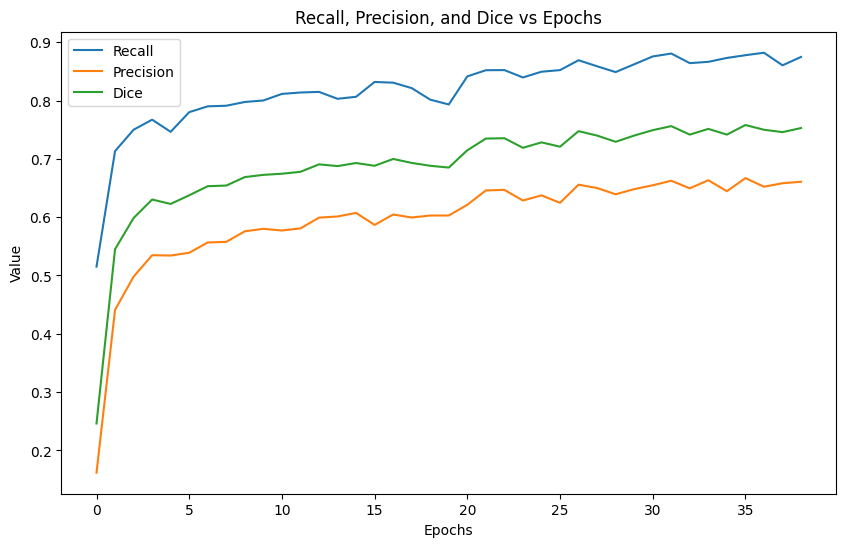

In [6]:
with open('history.json', 'r') as f:
    history = json.load(f)
    # Plotting recall, precision, and dice on the same graph
plt.figure(figsize=(10, 6))

# Assuming 'history' contains 'recall', 'precision', and 'dice' keys
plt.plot(history['recall'], label='Recall')
plt.plot(history['precision'], label='Precision')
plt.plot(history['dice'], label='Dice')

plt.title('Recall, Precision, and Dice vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

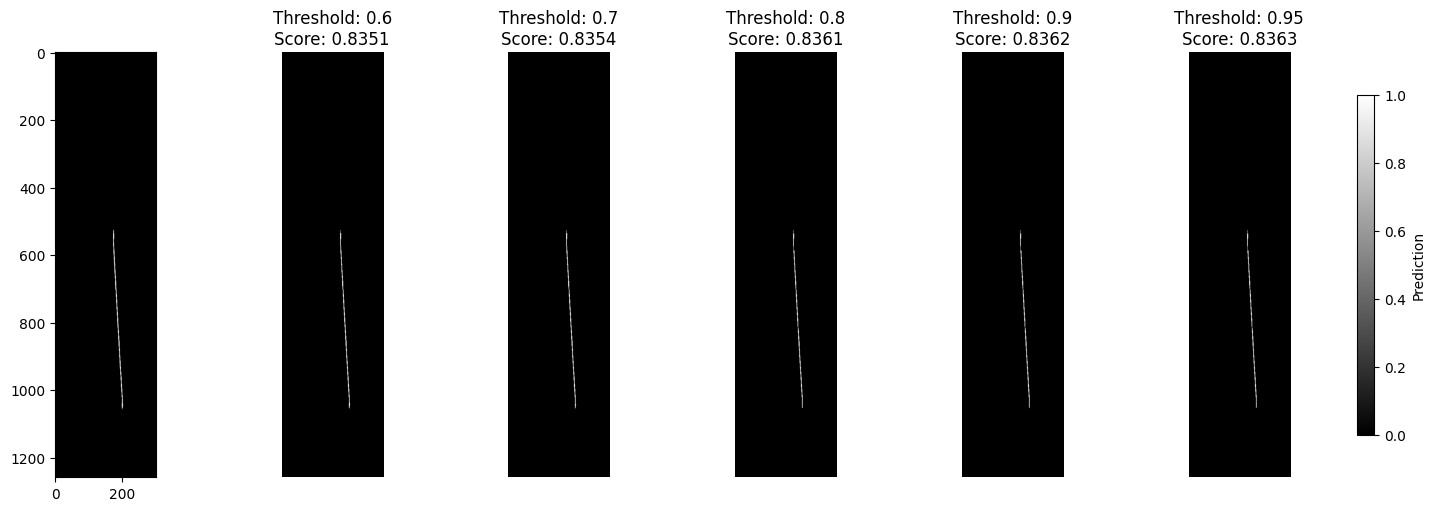

In [6]:
model = unet()
model.load_weights('20250103/083748.h5')
threshold_list = [0.6,0.7,0.8,0.9,0.95]
fig, axes = plt.subplots(1, len(threshold_list)+1, figsize=(15, 5), constrained_layout=True)
fault = np.load("validation_data/2023-10-05_d8f1c416/fault_segments_2023.76141493.npy")
seismic_data = np.load("validation_data/2023-10-05_d8f1c416/seismicCubes_RFC_fullstack_2023.76141493.npy")
seismic_data = butter_bandpass(seismic_data,5,30)
raw_pred = inference(model,seismic_data,raw=True)
raw_pred[:, :, :200] = 0
raw_pred[:, :, -20:] = 0
im = axes[0].imshow(raw_pred[220, ...].T, cmap="gray", vmin=0, vmax=1)
for i, threshold in enumerate(threshold_list):
    pred = (raw_pred > threshold).astype(np.uint8)
    dice = get_dice(pred,fault)
    im = axes[i+1].imshow(pred[220, ...].T, cmap="gray", vmin=0, vmax=1)  # Ensure shared scale
    axes[i+1].set_title(f"Threshold: {threshold}\nScore: {dice:.4f}")
    axes[i+1].axis("off")

fig.colorbar(im, ax=axes, orientation="vertical", shrink=0.8, label="Prediction")


### create submission

In [7]:
model = unet()
model.load_weights('20250103/083748.h5')
base_path = "testing_data"
submission_path = "submission_filtered.npz"
for sample_id in tqdm(os.listdir(base_path)):
    sample_path = os.path.join(base_path, sample_id)
    seismic_file = None
    for file in os.listdir(sample_path):
        if file.startswith("seismicCubes_") and file.endswith(".npy"):
            seismic_file = os.path.join(sample_path, file)
    seismic_data = np.load(seismic_file)
    seismic_data = butter_bandpass(seismic_data,5,30)
    pred = inference(model,seismic_data,0.9)
    pred[:, :, :200] = 0
    pred[:, :, -20:] = 0
    create_submission(sample_id, pred,submission_path)

  0%|          | 0/50 [00:00<?, ?it/s]

File not found, new submission will be created.
